# Convolutional Neural Networks (CNN)

Welcome to the wonderworld of CNNs™. If you followed the last lab session on pytorch, you should already be comfortable with Pytorch's autograd mechanism, and with the standard way to train a model. Today we will focus on convolutional neural nets, aka CNN, aka convnets. On the way, we will also get more familiar with the data loading mechanism from pytorch and the training loop. You have two goals:

1. Overfit a small subset of MNIST. This is a fast and reliable way to test that a model is not garbage.
2. reach the best possible test score on MNIST. Bon courage.

# Réseaux de Neurones Convolutionnels (RNC)
###### C'est un blague, personne n'utilise cet acronyme.

Bienvenu dans le monde merveilleux des CNNs™. Si vous avez suivi la dernière démonstration sur pytorch, vous devriez déjà être à l'aise avec le mécanisme de différentiation automatique, ainsi qu'avec la méthode standard pour entraîner un modèle. Aujourd'hui,  on va s'intéresser à toutes les subtilités des réseaux de neurones convolutionnels. Au passage on va revoir le mécanisme de chargement des données et la boucle d'entraînement. Vous avez deux buts:

1. mémoriser une petite fraction de MNIST avec un modèle. C'est une méthode simple et efficace pour vérifier qu'un modèle est décent.
2. atteindre le meilleur score possible sur MNIST entier. Good luck.



## Set up / Préparation

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip3 install torch torchvision


In [2]:
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

print(f"Your version of Pytorch is {torch.__version__}. You should use a version >0.4.")

Your version of Pytorch is 0.4.1. You should use a version >0.4.


In [3]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cpu


## Data / Données

In [4]:
# dataset

train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # Standardize with mean and std computed on train set
                       transforms.Normalize((0.1307,), (0.3081,)),
                   ]))

test_data = datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))


In [5]:
# size of the scratch training set
n_scratch = 64

# This parameter influences optimization
batch_size = 64
# This is just for evaluation, we want is as big as the GPU can support
batch_size_eval = 512


indices = list(range(len(train_data)))
random.shuffle(indices)

In [6]:
# DataLoaders

# This is the subset of MNIST we want to overfit
scratch_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    sampler=SubsetRandomSampler(indices[:n_scratch]),
    num_workers=1,
    pin_memory=use_cuda
)

# TODO: define a train, valid and test loader
# size of the validation set
n_valid = 15000

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[n_valid:]),
    #num_workers=1,
    pin_memory=use_cuda
)

valid_loader = DataLoader(
    train_data,
    batch_size=batch_size_eval,
    sampler=SubsetRandomSampler(indices[:n_valid]),
    #num_workers=1,
    pin_memory=use_cuda,
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    #num_workers=1,
    pin_memory=use_cuda,
)

# Extra Solution with `torch.utils.data.random_split`
#n_total = len(train_data)
#n_train = n_total - n_valid
#train_data, valid_data = torch.utils.data.random_split(train_data, n_train, n_valid)

This is the shape of one batch torch.Size([64, 1, 28, 28]). What is the meaning of each dimension?  batch size * channels * height * width
target torch.Size([64]) {tensor(4), tensor(9), tensor(1), tensor(5), tensor(1), tensor(8), tensor(2), tensor(7), tensor(8), tensor(8), tensor(8), tensor(1), tensor(4), tensor(2), tensor(4), tensor(4), tensor(3), tensor(7), tensor(0), tensor(1), tensor(5), tensor(9), tensor(5), tensor(0), tensor(1), tensor(7), tensor(2), tensor(8), tensor(6), tensor(6), tensor(2), tensor(0), tensor(1), tensor(2), tensor(8), tensor(4), tensor(2), tensor(3), tensor(3), tensor(6), tensor(8), tensor(4), tensor(4), tensor(1), tensor(6), tensor(2), tensor(5), tensor(1), tensor(9), tensor(5), tensor(5), tensor(6), tensor(9), tensor(2), tensor(4), tensor(5), tensor(2), tensor(4), tensor(1), tensor(6), tensor(9), tensor(5), tensor(6), tensor(8)}
torch.Size([28, 28])


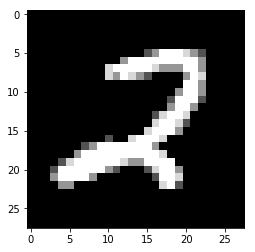

In [13]:
# visualize and understand the data
for inputs, targets in scratch_loader:
    print(f"This is the shape of one batch {inputs.shape}. What is the meaning of each dimension?  batch size * channels * height * width")
    print("target", targets.shape, set(targets))
    img = inputs[0,0]
    print(img.shape)
    plt.imshow(img, cmap='Greys_r')
    break

## Models / Modèles
You can find below a basic CNN. You will have to define your own model a bit later. First let's try to train this one!

Vous avez ci-dessous un CNN élémentaire. Vous devrez définir votre propre modèle un peu plus tard. Pour l'instant essayons déjà d'entraîner celui-ci.

In [8]:
class BasicNet(nn.Module):
    """Affordable convolutions for the people."""
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64*7*7, 10)

    def forward(self, xin):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = xin + F.relu(self.conv1(xin))
        x = F.max_pool2d(x, 2) 
        # x is [bs, 32, 14, 14]
        x = F.relu(self.bn(self.conv2(x)))
        x = F.max_pool2d(x, 2) 
        # x is [bs, 64, 7, 7]
        x = x.view(-1, 64*7*7 ) # flatten
        x = F.relu(self.fc(x))
        return x
    

## Training / Entraînement

You have to define general training and testing loops that can be applied to any pytorch module.

Vous devez définir des boucles d'entraînement et de test générales qui s'appliquent à n'importe quel module pytorch.

In [0]:
# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [0]:
def train(model,train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        
        # Let them code what's here
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        ###
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))
            

In [0]:
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            
            # let them code what's here
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

In [0]:
model = BasicNet().to(device)

lr = 0.0005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 100):
    train(model, scratch_loader, optimizer, epoch)
    loss, acc = test(model, scratch_loader)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/64 (0%)]	Loss: 2.349960

Test set: Average loss: 2.3370, Accuracy: 7/64 (11%)

Train Epoch: 2 [0/64 (0%)]	Loss: 2.342157

Test set: Average loss: 2.3259, Accuracy: 6/64 (9%)

Train Epoch: 3 [0/64 (0%)]	Loss: 2.327866

Test set: Average loss: 2.3118, Accuracy: 6/64 (9%)

Train Epoch: 4 [0/64 (0%)]	Loss: 2.309736

Test set: Average loss: 2.2982, Accuracy: 8/64 (12%)

Train Epoch: 5 [0/64 (0%)]	Loss: 2.291265

Test set: Average loss: 2.2836, Accuracy: 11/64 (17%)

Train Epoch: 6 [0/64 (0%)]	Loss: 2.273449

Test set: Average loss: 2.2722, Accuracy: 19/64 (30%)

Train Epoch: 7 [0/64 (0%)]	Loss: 2.259062

Test set: Average loss: 2.2627, Accuracy: 20/64 (31%)

Train Epoch: 8 [0/64 (0%)]	Loss: 2.247703

Test set: Average loss: 2.2538, Accuracy: 20/64 (31%)

Train Epoch: 9 [0/64 (0%)]	Loss: 2.237355

Test set: Average loss: 2.2444, Accuracy: 20/64 (31%)

Train Epoch: 10 [0/64 (0%)]	Loss: 2.227354

Test set: Average loss: 2.2336, Accuracy: 21/64 (33%)

Train Epoch: 11 [0/64 (0%

We have just applied our basic model on scratch_loader. A decent convnet with good parameters should be able to overfit this data easily.
What happened ? What do you conclude ?

On viens d'entraîner notre convnet de base sur scratch_loader. Un modèle décent devrait être capable de mémoriser ce dataset aisément. Que s'est-il passé? Qu'en concluez vous?


## Build your model

It's time to implement your own models to get the best clasification performance on MNIST.
First, try to overfit scratch_loader. Once you succeed, replace it by the real loaders and classify these digits!
You may consider the following ideas, ranked by relevance:

* batch norm
* more layers
* skip connections
* dropout (on the high level features)
* data augmentation with `transforms.RandomRotation`or `transforms.RandomAffine` at the dataset creation time

If you need some help to understand padding, stride etc..., [here](https://github.com/vdumoulin/conv_arithmetic) is very good resource from a Mila alumni.

You can use the cell below to compare the learning curves of your models. Don't forget to change the `'name'`value in the `results`dictionary between each try.

## Fabriquez votre modèle

Vous devez maintenant implémenter votre propre modèle. Essayez d'abord de mémoriser scratch_loader. Ensuite essayez de bien classifier MNIST. Vous pouvez considérer les idées suivantes classées selon la préférence de l'auteur ce ces lignes:

* normalisation de lot 
* réseau plus profond
* connections sautées
* abandon de neurones
* augmentation de données avec les méthodes `transforms.RandomRotation`ou `transforms.RandomAffine`  lors de la création du jeux de données.

Si vous ne connaissez pas ces notions, c'est normal. Regardez la version anglaise. 
Si vous avez voulez mieux comprendre le fonctionnement des couches convolutionnelles, regardez [ces merveilleux gifs](https://github.com/vdumoulin/conv_arithmetic) réalisés par un ancien du Mila.

Vous pouvez utiliser la cellule ci-dessous pour comparer vos courbes d'apprentissages entre elles. N'oubliez pas de changer  la valeur `'name'` dans le dictionnaire `results`  entre chaque essais.

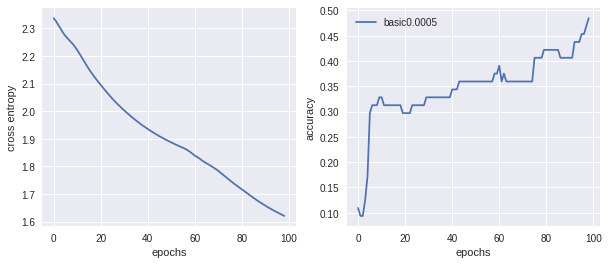

In [0]:
# PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for filename in os.listdir(savedir):
    if filename.endswith('.pkl'):
        with open(os.path.join(savedir, filename),'rb') as fin:
            results = pickle.load(fin)
            ax1.plot(results['loss'])
            ax1.set_ylabel('cross entropy')
            ax1.set_xlabel('epochs')
            
            ax2.plot(results['accuracy'], label = filename[:-4])
            ax2.set_ylabel('accuracy')
            ax2.set_xlabel('epochs')
            
plt.legend()

In [0]:
class AwesomeNet(nn.Module):
    """The MNIST killer net."""
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x[:,:,0,:10]
    

In [0]:
# TRAINING
model = HeavyNet().to(device)

lr = 0.005
optimizer = optim.Adam(model.parameters(), lr=lr)

results = {'name':'awesome', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)
    loss, acc = test(model, valid_loader)
    
    # save results
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/45056 (0%)]	Loss: 2.351320
Train Epoch: 1 [640/45056 (1%)]	Loss: 0.414239
Train Epoch: 1 [1280/45056 (3%)]	Loss: 0.124123
Train Epoch: 1 [1920/45056 (4%)]	Loss: 0.143542
Train Epoch: 1 [2560/45056 (6%)]	Loss: 0.131083
Train Epoch: 1 [3200/45056 (7%)]	Loss: 0.054203
Train Epoch: 1 [3840/45056 (9%)]	Loss: 0.190858
Train Epoch: 1 [4480/45056 (10%)]	Loss: 0.120072
Train Epoch: 1 [5120/45056 (11%)]	Loss: 0.066540
Train Epoch: 1 [5760/45056 (13%)]	Loss: 0.115501
Train Epoch: 1 [6400/45056 (14%)]	Loss: 0.109241
Train Epoch: 1 [7040/45056 (16%)]	Loss: 0.022404
Train Epoch: 1 [7680/45056 (17%)]	Loss: 0.116390
Train Epoch: 1 [8320/45056 (18%)]	Loss: 0.043814
Train Epoch: 1 [8960/45056 (20%)]	Loss: 0.052841
Train Epoch: 1 [9600/45056 (21%)]	Loss: 0.010785
Train Epoch: 1 [10240/45056 (23%)]	Loss: 0.103842
Train Epoch: 1 [10880/45056 (24%)]	Loss: 0.085207
Train Epoch: 1 [11520/45056 (26%)]	Loss: 0.167525
Train Epoch: 1 [12160/45056 (27%)]	Loss: 0.031070
Train Epoch: 1 [12800/45056

KeyboardInterrupt: ignored

In [0]:
class HeavyNet(nn.Module):
    """A medium sized network that performs very well on MNIST."""
    
    def __init__(self):
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # conv block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        # fully connected layers
        self.fc1 = nn.Linear(64*7*7, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2) # x is [bs, 32, 14, 14]
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2) # x is [bs, 64, 7, 7]
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    

If you want to learn more about Pytorch, here is a very comprehensive [tutorial](https://nbviewer.jupyter.org/github/ds4dm/tipsntricks/blob/master/pytorch/tutorial.ipynb) made by Mila for Mila. You are encouraged to look at it **after** this lab session.